# international_Migration/education

This note works with international migration with unemployment  

Meta Migration Data: https://data.humdata.org/dataset/international-migration-flows)    

Time? Season and School time

Special countries: BA, UA, XK, UK/GB, EL/GR 

In [1]:
import os
import gc
import rasterio
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import geopandas as gpd
from pathlib import Path
from osgeo import gdal, osr
import dask_geopandas as dgpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from scipy.stats import linregress

BASE_DIR = Path('/Users/wenlanzhang/PycharmProjects/Mapineq/src/data-wrangling/')
DATA_DIR = Path('/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford')

# Load & Clean Migration Data (International + NUTS)

In [2]:
# Step 1: Load international migration data
def load_international_migration(filepath):
    df = pd.read_csv(filepath)
    df['year'] = pd.to_datetime(df['migration_month']).dt.year
    df['month'] = pd.to_datetime(df['migration_month']).dt.month

    # Country code mapping
    country_code_mapping = {'GR': 'EL', 'GB': 'UK'}
    df['country_from'] = df['country_from'].replace(country_code_mapping)
    df['country_to'] = df['country_to'].replace(country_code_mapping)
    
    return df

migration_df = load_international_migration(DATA_DIR / "Migration/international_migration_flow.csv")
migration_df

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01,12,2019,1
1,AD,AE,2019-02,2,2019,2
2,AD,AE,2019-03,1,2019,3
3,AD,AE,2019-04,7,2019,4
4,AD,AE,2019-05,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08,138,2022,8
1563150,ZW,ZM,2022-09,162,2022,9
1563151,ZW,ZM,2022-10,149,2022,10
1563152,ZW,ZM,2022-11,104,2022,11


# Group by Month

In [3]:
# Group by destination country and month, summing migrant counts
monthly_migration = migration_df.groupby(['country_to', 'month'])['num_migrants'].sum().reset_index()
monthly_migration

,country_to,month,num_migrants
0,AD,1,2666
1,AD,2,3074
2,AD,3,2735
3,AD,4,2523
4,AD,5,2506
...,...,...,...
2155,ZW,8,13626
2156,ZW,9,14583
2157,ZW,10,16060
2158,ZW,11,13861


In [4]:
# Load a GeoJSON file
gdf_2024 = gpd.read_file(DATA_DIR/"NUTS/NUTS_RG_01M_2024_3035.geojson")

gdf_country_2024 = gdf_2024[gdf_2024['LEVL_CODE'] == 0]
gdf_country_2024 = gdf_country_2024[['CNTR_CODE', 'geometry']].reset_index(drop=True)
# gdf_country_2024

gdf_2021 = gpd.read_file(DATA_DIR/"NUTS/NUTS_RG_01M_2021_3035.geojson")

gdf_country_2021 = gdf_2021[gdf_2021['LEVL_CODE'] == 0]
gdf_country_2021 = gdf_country_2021[['CNTR_CODE', 'geometry']].reset_index(drop=True)
uk_2021 = gdf_country_2021[gdf_country_2021['CNTR_CODE'] == 'UK']
# uk_2021

# Concatenate with 2024 data
gdf_country = pd.concat(
    [gdf_country_2024, uk_2021],
    ignore_index=True  # Reset index
)
# gdf_country

country_list = gdf_country['CNTR_CODE'].unique()
len(country_list)
country_list

array(['EL', 'ES', 'FI', 'FR', 'HR', 'EE', 'DE', 'DK', 'BA', 'AT', 'BG',
       'CH', 'CY', 'BE', 'CZ', 'AL', 'LU', 'LV', 'ME', 'IE', 'IS', 'IT',
       'MK', 'MT', 'LI', 'NL', 'LT', 'HU', 'RS', 'SE', 'SI', 'TR', 'UA',
       'SK', 'RO', 'NO', 'PL', 'PT', 'XK', 'UK'], dtype=object)

In [5]:
monthly_migration = monthly_migration[monthly_migration['country_to'].isin(country_list)]
monthly_migration

,country_to,month,num_migrants
36,AL,1,10515
37,AL,2,10614
38,AL,3,10404
39,AL,4,8497
40,AL,5,9458
...,...,...,...
2107,XK,8,5821
2108,XK,9,5280
2109,XK,10,5838
2110,XK,11,4714


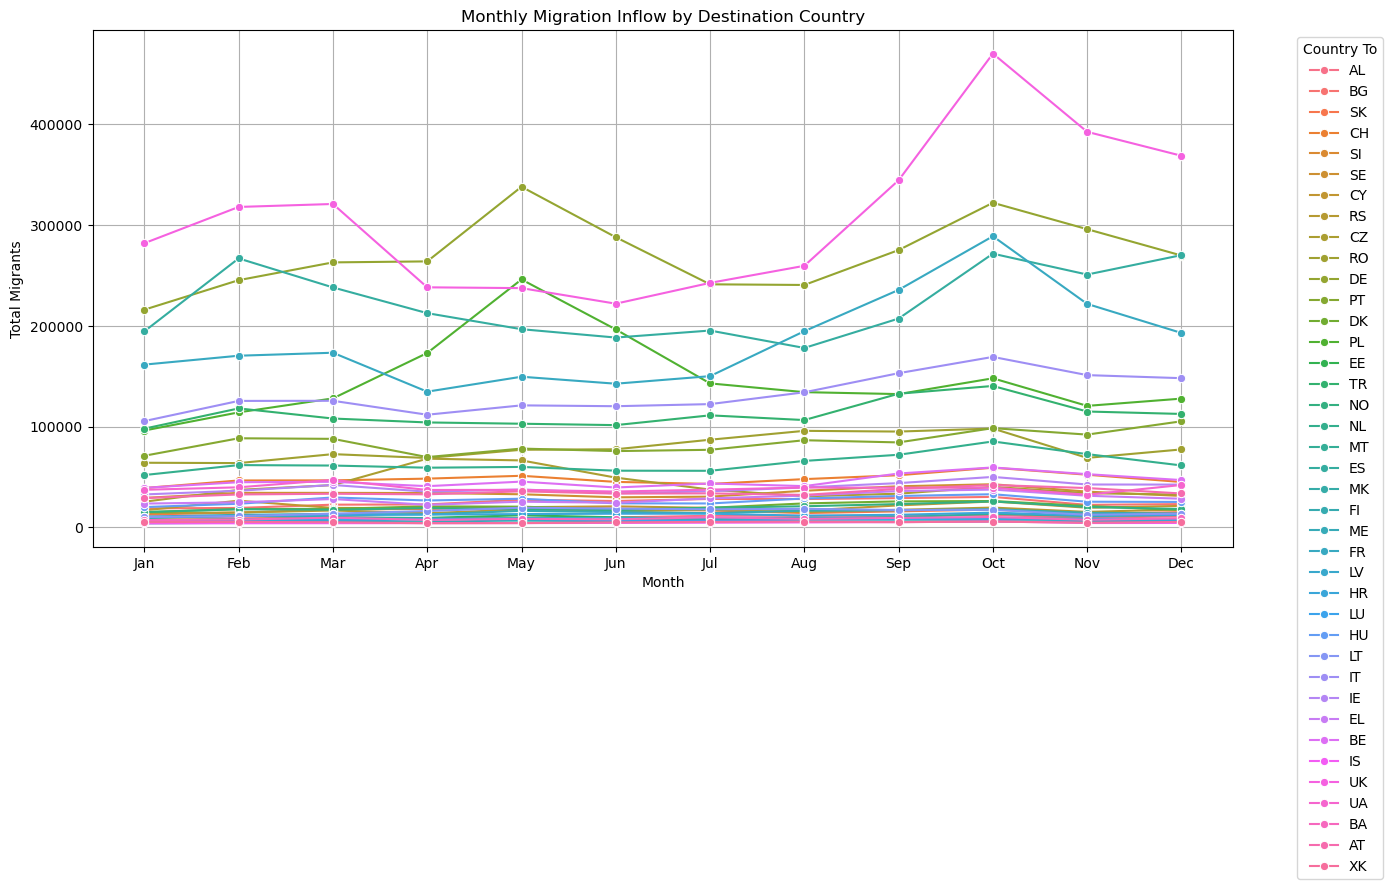

In [6]:
# Optional: sort by month to keep x-axis clean
monthly_migration = monthly_migration.sort_values(by='month')

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_migration, x='month', y='num_migrants', hue='country_to', marker='o')

plt.title('Monthly Migration Inflow by Destination Country')
plt.xlabel('Month')
plt.ylabel('Total Migrants')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Country To', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
# Filter for October only (month 10) and countries in country_list
october_df = monthly_migration[(monthly_migration['month'] == 10) & (monthly_migration['country_to'].isin(country_list))]

# Group by destination country and sum number of migrants
october_totals = october_df.groupby('country_to')['num_migrants'].sum()

# Sort and get top 5
top5_october = october_totals.sort_values(ascending=False).head(5)

# Display result
print("Top 5 Destination Countries in October (by total migrants):")
print(top5_october)

Top 5 Destination Countries in October (by total migrants):
country_to
UK    470151
DE    322137
FR    288935
ES    271650
IT    169220
Name: num_migrants, dtype: int64


# Group by year and month

In [9]:
# Group by destination country and month, summing migrant counts
inflow_migration = migration_df.groupby(['country_to', 'month', 'year'])['num_migrants'].sum().reset_index()
inflow_migration

,country_to,month,year,num_migrants
0,AD,1,2019,600
1,AD,1,2020,641
2,AD,1,2021,668
3,AD,1,2022,757
4,AD,2,2019,576
...,...,...,...,...
8635,ZW,11,2022,6472
8636,ZW,12,2019,3270
8637,ZW,12,2020,3266
8638,ZW,12,2021,3081


In [13]:
inflow_migration[(inflow_migration['country_to']=='DE') & (inflow_migration['month']==5)]

,country_to,month,year,num_migrants
1936,DE,5,2019,58766
1937,DE,5,2020,21402
1938,DE,5,2021,42170
1939,DE,5,2022,215682


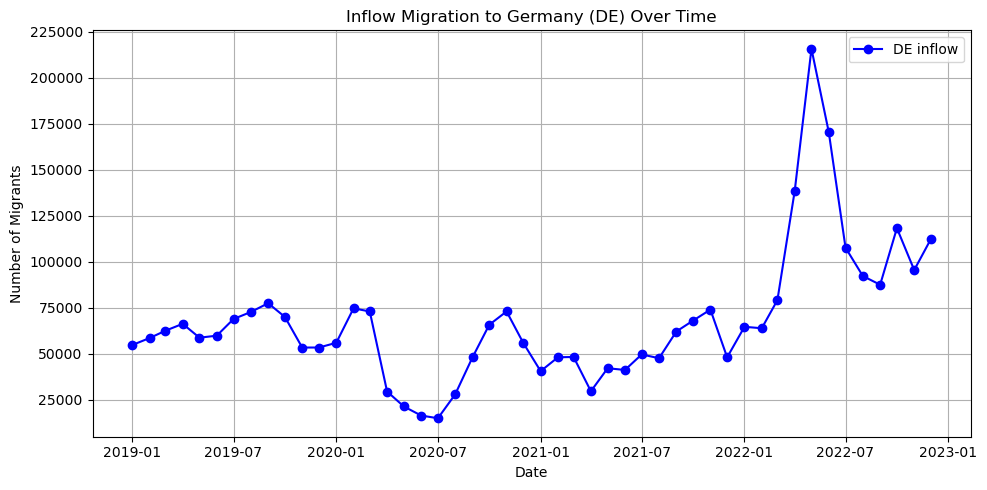

In [15]:
# Step 1: Filter for 'DE'
de_data = inflow_migration[inflow_migration['country_to'] == 'DE'].copy()

# Step 2: Create a datetime column
de_data['date'] = pd.to_datetime(de_data[['year', 'month']].assign(day=1))

# Step 3: Sort by date (optional but good practice)
de_data.sort_values('date', inplace=True)

# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(de_data['date'], de_data['num_migrants'], marker='o', color='blue', label='DE inflow')
plt.title('Inflow Migration to Germany (DE) Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Migrants')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
max_row = de_data.loc[de_data['num_migrants'].idxmax()]
print(max_row)

country_to                       DE
month                             5
year                           2022
num_migrants                 215682
date            2022-05-01 00:00:00
Name: 1939, dtype: object


**DE**
1. Activation of the EU Temporary Protection Directive
On March 4, 2022, the European Union activated the Temporary Protection Directive in response to the mass displacement caused by Russia's invasion of Ukraine. This directive provided immediate protection and residence rights to Ukrainian refugees across EU member states, including Germany, without the need for individual asylum applications. The directive aimed to alleviate pressure on national asylum systems and ensure a coordinated response to the crisis. 
consilium.europa.eu

2. Implementation of the Ukraine Residence Transitional Regulation
On March 7, 2022, Germany introduced the Ukraine Residence Transitional Regulation (Ukraine-Aufenthalts-Übergangsverordnung). This regulation temporarily legalized the entry and residence of Ukrainians and third-country nationals legally residing in Ukraine at the time of the Russian invasion. It allowed them to stay in Germany without undergoing the standard asylum procedure. The regulation was extended multiple times throughout 2022 to accommodate the ongoing crisis. 
en.wikipedia.org
reuters.com

3. Provision of Basic State Benefits
From June 1, 2022, war refugees from Ukraine were granted basic state benefits equivalent to those received by long-term unemployed individuals under the Hartz IV scheme. This included access to higher benefits, better healthcare, and support for integration into the labor market. The decision was made by Germany's federal and state governments to facilitate the inclusion of Ukrainian refugees into society. 

4. Increased Refugee Arrivals
Germany registered a significant number of arrivals from Ukraine in April 2022, with approximately 198,000 individuals entering the country. The majority of these refugees were women and children. This influx placed considerable strain on Germany's accommodation and integration systems. 
reddit.com

These measures and developments in April 2022 were pivotal in shaping Germany's response to the migration crisis resulting from the war in Ukraine.

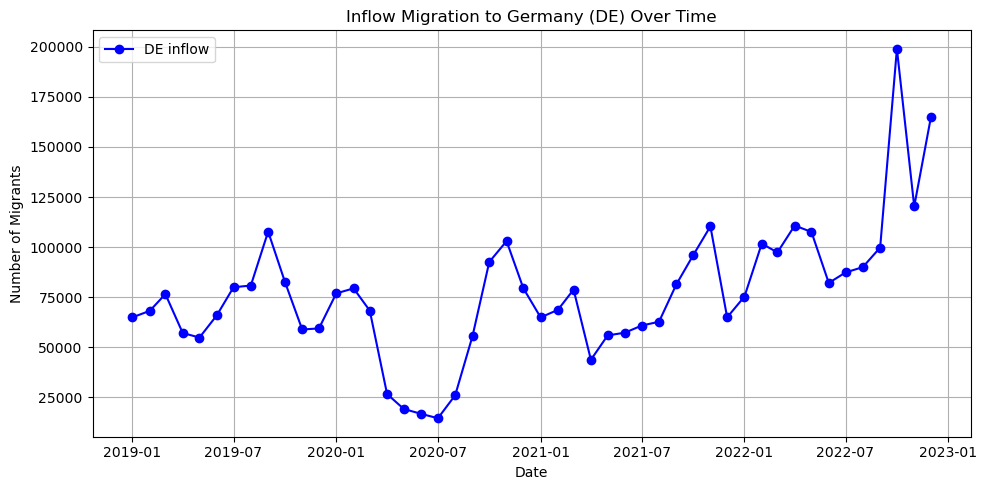

In [17]:
# Step 1: Filter for 'DE'
de_data = inflow_migration[inflow_migration['country_to'] == 'UK'].copy()

# Step 2: Create a datetime column
de_data['date'] = pd.to_datetime(de_data[['year', 'month']].assign(day=1))

# Step 3: Sort by date (optional but good practice)
de_data.sort_values('date', inplace=True)

# Step 4: Plot
plt.figure(figsize=(10, 5))
plt.plot(de_data['date'], de_data['num_migrants'], marker='o', color='blue', label='DE inflow')
plt.title('Inflow Migration to Germany (DE) Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Migrants')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**UK**  
Key Policy Changes in November and December 2022
1. Seasonal Worker Visa for Poultry Sector
To address labor shortages in the poultry industry, the UK introduced a seasonal worker visa for specific roles in this sector. This visa was valid from 18 October to 31 December 2022, with applications required by 15 November. Applicants needed to meet certain wage and work-hour criteria. 

2. Suspension of Police Registration Scheme
The UK suspended the police registration requirement for foreign nationals starting from 9 November 2022. This change aimed to reduce administrative burdens, as immigration data is now collected during the visa application process. 

3. Changes to Hong Kong British Nationals (Overseas) Scheme
From 30 November 2022, eligible adult children of Hong Kong British Nationals (Overseas) were allowed to apply independently for UK visas, along with their dependents. This policy aimed to facilitate family reunification and increase migration from Hong Kong. 

4. Inclusion of Colombia, Guyana, and Peru as Non-Visa Nationals
Citizens of Colombia, Guyana, and Peru were granted non-visa national status from 9 November 2022. This status allows them to enter the UK without a visa for short stays, potentially increasing short-term migration from these countries. 


# Test anomalous in Oct

## 🧪 A. One-Way ANOVA / Kruskal-Wallis

In [14]:
from scipy.stats import kruskal

# For a specific country, e.g., 'DE'
country_df = migration_df[migration_df['country_to'] == 'DE']

# Create list of monthly migrant counts
month_groups = [country_df[country_df['month'] == m]['num_migrants'] for m in range(1, 13)]

# Kruskal-Wallis test (non-parametric ANOVA)
stat, p = kruskal(*month_groups)

print(f"Kruskal-Wallis H-test: H={stat:.2f}, p={p:.4f}")


Kruskal-Wallis H-test: H=41.30, p=0.0000


There are significant differences between months overall.

## 📈 B. Time Series Decomposition

> If you have enough data (multiple years), you can decompose it into:
Trend, Seasonality, Residuals

📊 What You’re Looking At
Each row in your figure corresponds to:

1. Observed (num_migrants)
- This is the original time series — the total number of migrants over time.
- You can observe overall fluctuations, peaks, and trends.
- Look for recurring patterns (e.g., annual peaks).

2. Trend
- This line shows the long-term movement in the data, smoothing out short-term fluctuations.
- It tells you whether migration is increasing or decreasing over time (independent of seasons).
- In your plot, the trend is increasing steadily from around early 2021 onward.

3. Seasonal
- This captures repeating patterns that occur in fixed intervals (monthly, yearly, etc.).
- In your case, it's clearly cyclical: a similar pattern repeats roughly every 12 months.
- Notice how the October values are the seasonal peaks — confirming your hypothesis.

💡 Each peak or trough shows how that month typically deviates from the trend.

4. Residual (Noise)
- This is what’s left over after removing the trend and seasonal parts.
- It shows random variation that can't be explained by seasonality or trend.
- Ideally, residuals should look like random scatter — which yours mostly do.

🔍 How to Use It  
To detect a peak in October, you're especially interested in the Seasonal component:

Example:
- If October consistently shows a positive seasonal value (e.g., +20,000),
→ it means migration tends to be 20,000 higher than the monthly average for that trend level.
- If this pattern repeats every year, it's strong seasonal evidence.

✅ Why It’s Useful
This decomposition gives you a clean, interpretable breakdown:

- 📈 Long-term growth (Trend)
- 🔁 Repeating cycles (Seasonal)
- 🔬 Random shocks (Residual)

It helps distinguish:

- "Migration is increasing" vs
- "Migration always peaks in October" vs
- "This one spike was random"



| Component    | Tells You         | What You See                |
| ------------ | ----------------- | --------------------------- |
| **Observed** | The actual data   | Peaks and dips              |
| **Trend**    | Overall direction | Long-term rise from 2021    |
| **Seasonal** | Repeating pattern | October peak every year     |
| **Residual** | Random noise      | Scattered, no clear pattern |


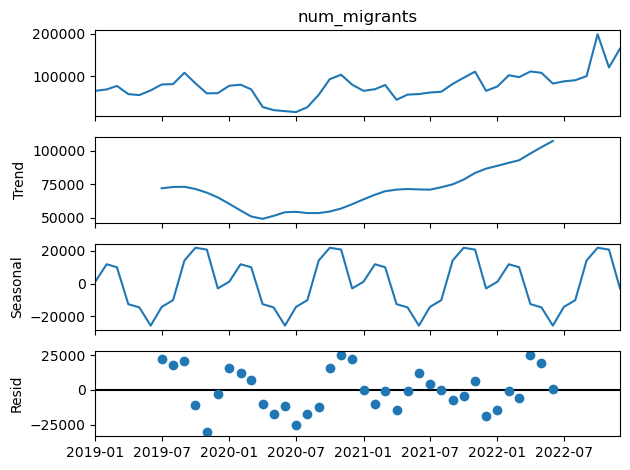

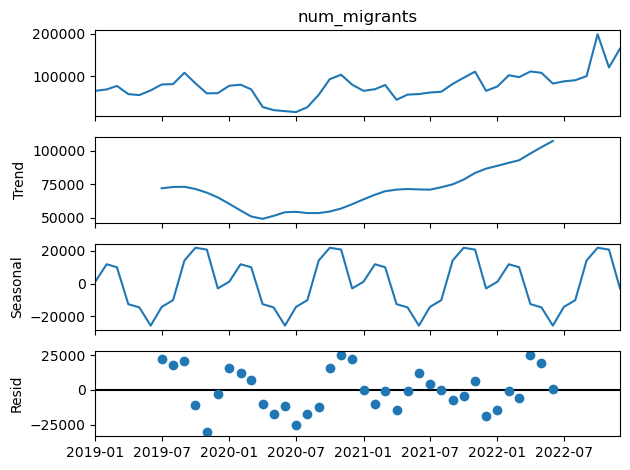

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Prepare time series: total migrants per month for a country
country_df = migration_df[migration_df['country_to'] == 'UK']
ts = country_df.groupby('migration _month')['num_migrants'].sum()
ts.index = pd.to_datetime(ts.index)

# Decompose
decomp = seasonal_decompose(ts, model='additive', period=12)
decomp.plot()

📈 Seasonal Decomposition (Plot You Provided)
The seasonal component shows clear positive peaks every 12 months.

The peaks align with October, confirmed visually.

The trend is upward over time, but the seasonal variation persists consistently.

## 📊 C. Z-Score or T-Test for October vs Others

In [19]:
from scipy.stats import ttest_ind

oct_values = country_df[country_df['month'] == 10]['num_migrants']
other_values = country_df[country_df['month'] != 10]['num_migrants']

t_stat, p_val = ttest_ind(oct_values, other_values, alternative='greater')  # one-sided test
print(f"T-test result: t={t_stat:.2f}, p={p_val:.4f}")


T-test result: t=4.23, p=0.0000


⇒ October has significantly more migrants than other months.

Very strong evidence (p < 0.001).

So you have:

✅ Visual evidence of a recurring October peak

✅ Statistical confirmation of its significance

✅ Applicability across multiple years (2019–2022)


🔍 Suggested Next Steps
Repeat the same analysis for other top countries (DE, FR, UK, IT, ES, etc.)

Normalize migration per capita for fair comparison

Correlate peaks with known academic calendars, or plot side-by-side

(Optional) Fit a seasonal ARIMA (SARIMA) model if forecasting is desired

Would you like help automating this test across countries or visualizing a heatmap of migration peaks per country per month?

In [27]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_strength(ts, period=12):
    decomposition = seasonal_decompose(ts, model='additive', period=period)
    
    seasonal = decomposition.seasonal
    resid = decomposition.resid
    
    # Remove NaNs for variance calculation
    valid = (~seasonal.isna()) & (~resid.isna())
    s_var = np.var(seasonal[valid])
    r_var = np.var(resid[valid])
    
    strength = 1 - (r_var / (r_var + s_var))
    return strength, decomposition

# Example for one country, e.g., 'DE'
country_code = 'ES'
country_df = migration_df[migration_df['country_to'] == country_code]
ts = country_df.groupby('migration_month')['num_migrants'].sum()
ts.index = pd.to_datetime(ts.index)

strength, decomp = seasonal_strength(ts)
print(f"Seasonal Strength for {country_code}: {strength:.2f}")

Seasonal Strength for ES: 0.36


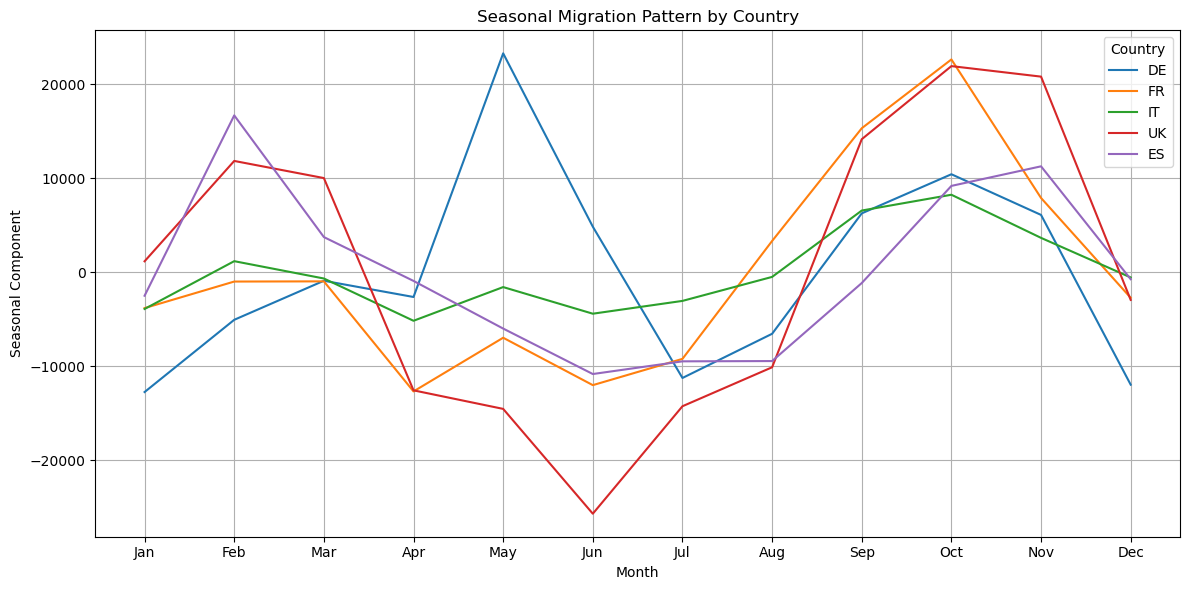

In [24]:
import matplotlib.pyplot as plt

countries = ['DE', 'FR', 'IT', 'UK', 'ES']  # Pick a few key countries

plt.figure(figsize=(12, 6))

for country in countries:
    country_df = migration_df[migration_df['country_to'] == country]
    ts = country_df.groupby('migration_month')['num_migrants'].sum()
    ts.index = pd.to_datetime(ts.index)

    try:
        _, decomp = seasonal_strength(ts)
        seasonal = decomp.seasonal
        monthly_avg = seasonal.groupby(seasonal.index.month).mean()
        plt.plot(range(1, 13), monthly_avg, label=country)
    except:
        continue

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Seasonal Component')
plt.title('Seasonal Migration Pattern by Country')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()
plt.show()

🔢 1. Z-Score for October (vs other months)
Compute how much October’s average seasonal value deviates from the rest.

In [29]:
oct_seasonal = monthly_avg[10]  # October (index starts from 1)
other_months = [v for i, v in enumerate(monthly_avg) if i != 10]

z_score = (oct_seasonal - np.mean(other_months)) / np.std(other_months)
print(f"October Z-score: {z_score:.2f}")

October Z-score: 1.28


| Metric            | Tells You                                 | Focuses on October? |
| ----------------- | ----------------------------------------- | ------------------- |
| Seasonal Strength | Repeating pattern strength (any month)    | ❌                   |
| October Z-score   | How extreme October is vs other months    | ✅                   |
| Month Rank        | Is October among top seasonal months?     | ✅                   |
| October Ratio     | How strong October is compared to average | ✅                   |


In [3]:
migration_df

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01,12,2019,1
1,AD,AE,2019-02,2,2019,2
2,AD,AE,2019-03,1,2019,3
3,AD,AE,2019-04,7,2019,4
4,AD,AE,2019-05,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08,138,2022,8
1563150,ZW,ZM,2022-09,162,2022,9
1563151,ZW,ZM,2022-10,149,2022,10
1563152,ZW,ZM,2022-11,104,2022,11


In [5]:
import pandas as pd

# Load Meta migration data

# Convert migration_month to datetime and extract year
migration_df['migration_month'] = pd.to_datetime(migration_df['migration_month'])
migration_df['year'] = migration_df['migration_month'].dt.year

# Aggregate by year and country pair
meta_agg = migration_df.groupby(['country_from', 'country_to', 'year'])['num_migrants'].sum().reset_index()
meta_agg

,country_from,country_to,year,num_migrants
0,AD,AE,2019,58
1,AD,AE,2020,30
2,AD,AE,2021,24
3,AD,AE,2022,40
4,AD,AF,2019,16
...,...,...,...,...
128821,ZW,ZA,2022,23268
128822,ZW,ZM,2019,1409
128823,ZW,ZM,2020,946
128824,ZW,ZM,2021,1134


	 	Mobile students from abroad enrolled by education level, sex and field of education (educ_uoe_mobs01)	 
 	Mobile students from abroad enrolled by education level, sex and country of origin (educ_uoe_mobs02)

In [65]:
# Load Eurostat data
eurostat_raw = pd.read_csv(DATA_DIR / "Migration/eurostat/estat_educ_uoe_mobs02.tsv", sep='\t')
eurostat_raw

,"freq,unit,partner,sex,isced11,geo\TIME_PERIOD",2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,"A,NR,AD,F,ED5,AL",:,:,:,:,:,:,:,:,:,0,0,0
1,"A,NR,AD,F,ED5,AT",:,0,0,0,0,0,0,0,0,0,0,0
2,"A,NR,AD,F,ED5,BA",:,:,:,:,:,:,: m,: m,: m,: m,:,:
3,"A,NR,AD,F,ED5,BE",:,0,0,0,0,0,0,0,0 bd,0,0,0
4,"A,NR,AD,F,ED5,BG",:,: m,: m,: m,: m,: m,: m,: m,: m,: m,: m,: m
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130546,"A,NR,ZW,T,ED8,SE",:,6,7,7,7,8,8,9,8,7,10,13
130547,"A,NR,ZW,T,ED8,SI",:,0,0,: @C,: @C,: @C,: @C,: @C,: @C,: @C,: @C,: @C
130548,"A,NR,ZW,T,ED8,SK",:,0,0,0,0,0,0,0,0,0,0,0
130549,"A,NR,ZW,T,ED8,TR",:,:,0,3,3,10,10,8,10,9,8,:


In [66]:
# Split the multi-column key
eurostat_raw[['freq', 'unit', 'partner', 'sex', 'isced11', 'geo']] = eurostat_raw[
    'freq,unit,partner,sex,isced11,geo\\TIME_PERIOD'
].str.split(',', expand=True)

# Drop the combined key column
eurostat_raw.drop(columns=['freq,unit,partner,sex,isced11,geo\\TIME_PERIOD'], inplace=True)

# Melt the year columns into long format
eurostat_long = eurostat_raw.melt(
    id_vars=['freq', 'unit', 'partner', 'sex', 'isced11', 'geo'],
    var_name='year',
    value_name='value_raw'
)
eurostat_long

,freq,unit,partner,sex,isced11,geo,year,value_raw
0,A,NR,AD,F,ED5,AL,2012,:
1,A,NR,AD,F,ED5,AT,2012,:
2,A,NR,AD,F,ED5,BA,2012,:
3,A,NR,AD,F,ED5,BE,2012,:
4,A,NR,AD,F,ED5,BG,2012,:
...,...,...,...,...,...,...,...,...
1566607,A,NR,ZW,T,ED8,SE,2023,13
1566608,A,NR,ZW,T,ED8,SI,2023,: @C
1566609,A,NR,ZW,T,ED8,SK,2023,0
1566610,A,NR,ZW,T,ED8,TR,2023,:


In [67]:
# Remove footnotes and special characters
eurostat_long['value'] = eurostat_long['value_raw'].str.extract(r'(\d+\.?\d*)')  # Extract numeric part
eurostat_long['value'] = pd.to_numeric(eurostat_long['value'], errors='coerce')  # Convert to float

# Filter to tertiary education (usually ISCED11 = ED5-8, here looks like ED5 is used)
tertiary_df = eurostat_long[
    eurostat_long['isced11'].isin(['ED5', 'ED5-8'])  # Modify as needed
]
eurostat_long['year'] = pd.to_numeric(eurostat_long['year'], errors='coerce')

eurostat_long = eurostat_long[
    (eurostat_long['year'].between(2019, 2022)) &
    (eurostat_long['sex'] == 'T') &
    (eurostat_long['isced11'] == 'ED5-8') 
]

eurostat_long = eurostat_long[['partner', 'geo', 'year', 'value']]
eurostat_long
# eurostat_long['partner'].unique()

,partner,geo,year,value
914279,AD,AL,2019,NaN
914280,AD,AT,2019,0.0
914281,AD,BE,2019,2.0
914282,AD,BG,2019,0.0
914283,AD,CH,2019,3.0
...,...,...,...,...
1435942,ZW,SE,2022,50.0
1435943,ZW,SI,2022,NaN
1435944,ZW,SK,2022,2.0
1435945,ZW,TR,2022,162.0


| Code      | ISCED Level Description                    |
| --------- | ------------------------------------------ |
| **ED5**   | Level 5: Short-cycle tertiary education    |
| **ED5-8** | A combined category for levels 5 through 8 |
| **ED6**   | Level 6: Bachelor's or equivalent          |
| **ED7**   | Level 7: Master's or equivalent            |
| **ED8**   | Level 8: Doctoral or equivalent            |

Special regional aggregates:
- AFR = Africa (aggregate)
- AME_N = Northern America
- AME_X_N = Central and South America
- ASI = Asia
- EUR = Europe (non-EU sometimes)
- EU27_2020 = European Union (27 countries as of 2020)
- EU28 = European Union (including UK pre-Brexit)

In [30]:
meta_agg

,country_from,country_to,year,num_migrants
0,AD,AE,2019,58
1,AD,AE,2020,30
2,AD,AE,2021,24
3,AD,AE,2022,40
4,AD,AF,2019,16
...,...,...,...,...
128821,ZW,ZA,2022,23268
128822,ZW,ZM,2019,1409
128823,ZW,ZM,2020,946
128824,ZW,ZM,2021,1134


In [31]:
# Ensure 'year' is the same type in both datasets (int or str — choose one)
meta_agg['year'] = meta_agg['year'].astype(int)
tertiary_df['year'] = tertiary_df['year'].astype(int)

# Ensure country codes match in format (e.g. uppercase, no whitespace)
meta_agg['country_to'] = meta_agg['country_to'].str.strip().str.upper()
tertiary_df['geo'] = tertiary_df['geo'].str.strip().str.upper()


/var/folders/2_/nk9j6sb901n_fk5dz_9vtqj80000gn/T/ipykernel_99666/1477220880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tertiary_df['year'] = tertiary_df['year'].astype(int)
/var/folders/2_/nk9j6sb901n_fk5dz_9vtqj80000gn/T/ipykernel_99666/1477220880.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tertiary_df['geo'] = tertiary_df['geo'].str.strip().str.upper()


In [32]:
# Remove rows with no tertiary student data
tertiary_df = eurostat_long[
    (eurostat_long['isced11'].isin(['ED5', 'ED5-8'])) &  # Tertiary level
    (eurostat_long['value'].notna())
]
tertiary_df

,freq,unit,isced11,iscedf13,sex,geo,year,value_raw,value
49496,A,NR,ED5-8,TOTAL,T,BG,2012,11214,11214.0
49497,A,NR,ED5-8,TOTAL,T,CH,2012,44468,44468.0
49500,A,NR,ED5-8,TOTAL,T,DE,2012,184594,184594.0
122751,A,NR,ED5,F00,F,CH,2013,0 d,0.0
122754,A,NR,ED5,F00,F,DE,2013,0,0.0
...,...,...,...,...,...,...,...,...,...
1399844,A,NR,ED5-8,UNK,T,RO,2023,0,0.0
1399845,A,NR,ED5-8,UNK,T,RS,2023,0,0.0
1399846,A,NR,ED5-8,UNK,T,SE,2023,51,51.0
1399847,A,NR,ED5-8,UNK,T,SI,2023,0,0.0


In [33]:
merged = pd.merge(
    meta_agg,
    tertiary_df,
    left_on=['country_to', 'year'],
    right_on=['geo', 'year'],
    how='inner'
)

# Rename for clarity
merged = merged.rename(columns={
    'num_migrants': 'meta_migrants',
    'value': 'tertiary_students'
})

# Optional: Drop unnecessary columns
merged = merged[['country_from', 'country_to', 'year', 'meta_migrants', 'tertiary_students']]
merged

ValueError: You are trying to merge on int64 and object columns for key 'year'. If you wish to proceed you should use pd.concat

In [29]:
# meta_agg has columns: country_from, country_to, year, num_migrants
meta_agg['year'] = meta_agg['year'].astype(str)  # Ensure year is string to match Eurostat data

# Merge using 'geo' as country_to and year
merged = pd.merge(
    meta_agg,
    tertiary_df,
    left_on=['country_to', 'year'],
    right_on=['geo', 'year'],
    how='inner'
)

# Rename for clarity
merged = merged.rename(columns={
    'num_migrants': 'meta_migrants',
    'value': 'tertiary_students'
})
merged

,country_from,country_to,year,meta_migrants,freq,unit,isced11,iscedf13,sex,geo,value_raw,tertiary_students
